<a href="https://www.kaggle.com/code/bhavinmoriya/python-for-finance-stochastic-2?scriptVersionId=115603954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This NB is a continuation of the : https://www.kaggle.com/code/bhavinmoriya/python-for-finance-stochastic-1

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import numpy.random as npr
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn as sns
import math

from datetime import datetime as dt, timedelta as td
sns.set()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Generate Standard normal distribution.

We know that ```npr.standard_normal()``` gives Standard normal distribution. Thing is if we simulate than we see that, for small sample size it does not give mean 0 and std 1 dist. For fairly large sample we get about mean 0 and std 1 dist. To solve this we have the following function.

**PS : MEAN, STD == 1st moment, 2nd moment**

In [2]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    ''' Function to generate random numbers for simulation.
    Parameters
    ==========
    M: int
    number of time intervals for discretization
    I: int
    number of paths to be simulated
    anti_paths: boolean
    use of antithetic variates
    mo_math: boolean
    use of moment matching
    '''
    if anti_paths is True:
        sn = npr.standard_normal((M + 1, int(I / 2)))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = npr.standard_normal((M + 1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

# Valuation
One of the most important applications of Monte Carlo simulation is the valuation of
contingent claims (options, derivatives, hybrid instruments, etc.). Simply stated, in a
risk-neutral world, the value of a contingent claim is the discounted expected payoff
under the risk-neutral (martingale) measure. This is the probability measure that
makes all risk factors (stocks, indices, etc.) drift at the riskless short rate, making the
discounted processes martingales. According to the Fundamental Theorem of Asset
Pricing, the existence of such a probability measure is equivalent to the absence of
arbitrage.

A financial option embodies the right to buy (call option) or sell (put option) a specified financial instrument at a given maturity date (European option), or over a specified period of time (American option), at a given price (strike price). Let us first
consider the simpler case of European options in terms of valuation.

# European Options
The payoff of a European call option on an index at maturity is given by $h(S_T )=
max(S_T – K, 0),$ where $S_T$ is the index level at maturity date $T$ and $K$ is the strike price.
Given a, or in complete markets the, risk-neutral measure for the relevant stochastic
process (e.g., geometric Brownian motion),

In [3]:
# Monte Carlo estimator for the European option

S0 = 100.
r = 0.05
sigma = 0.25
T = 1.0
I = 50000

def gbm_mcs_stat(K):
    ''' Valuation of European call option in Black-Scholes-Merton
    by Monte Carlo simulation (of index level at maturity)
    Parameters
    ==========
    K: float
    (positive) strike price of the option
    Returns
    =======
    C0: float
    estimated present value of European call option
    '''
    sn = gen_sn(1, I)
    # simulate index level at maturity
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T\
    + sigma * math.sqrt(T) * sn[1])
    # calculate payoff at maturity
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator
    C0 = math.exp(-r * T) * np.mean(hT)
    return C0

In [4]:
gbm_mcs_stat(K=105)

9.956890943820234

Next, consider the dynamic simulation approach and allow for European put options
in addition to the call option. The function gbm_mcs_dyna() implements the algo‐
rithm. The code also compares option price estimates for a call and a put stroke at the
same level

In [5]:
M = 50

def gbm_mcs_dyna(K, option='call'):
    ''' Valuation of European options in Black-Scholes-Merton
    by Monte Carlo simulation (of index level paths)
    Parameters
    ==========
    K: float
    (positive) strike price of the option
    option : string
    type of the option to be valued ('call', 'put')
    Returns
    =======
    C0: float
    estimated present value of European call option
    '''
    dt = T / M
    # simulation of index level paths
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt\
                                 + sigma * math.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    # calculation of MCS estimator
    C0 = math.exp(-r * T) * np.mean(hT)
    return C0

In [6]:
gbm_mcs_dyna(K=110., option='call'), gbm_mcs_dyna(K=110., option='put')

(7.9699766483620795, 12.67833872142193)

In [7]:
strikes = np.arange(90,111)
calls = [gbm_mcs_dyna(K=k, option='call') for k in strikes]
puts = [gbm_mcs_dyna(K=k, option='put') for k in strikes]
call_put = np.array([calls,puts])
df = pd.DataFrame(index=strikes,
            columns=['CallPrice', 'PutPrice'],
            data=np.array(call_put.T))

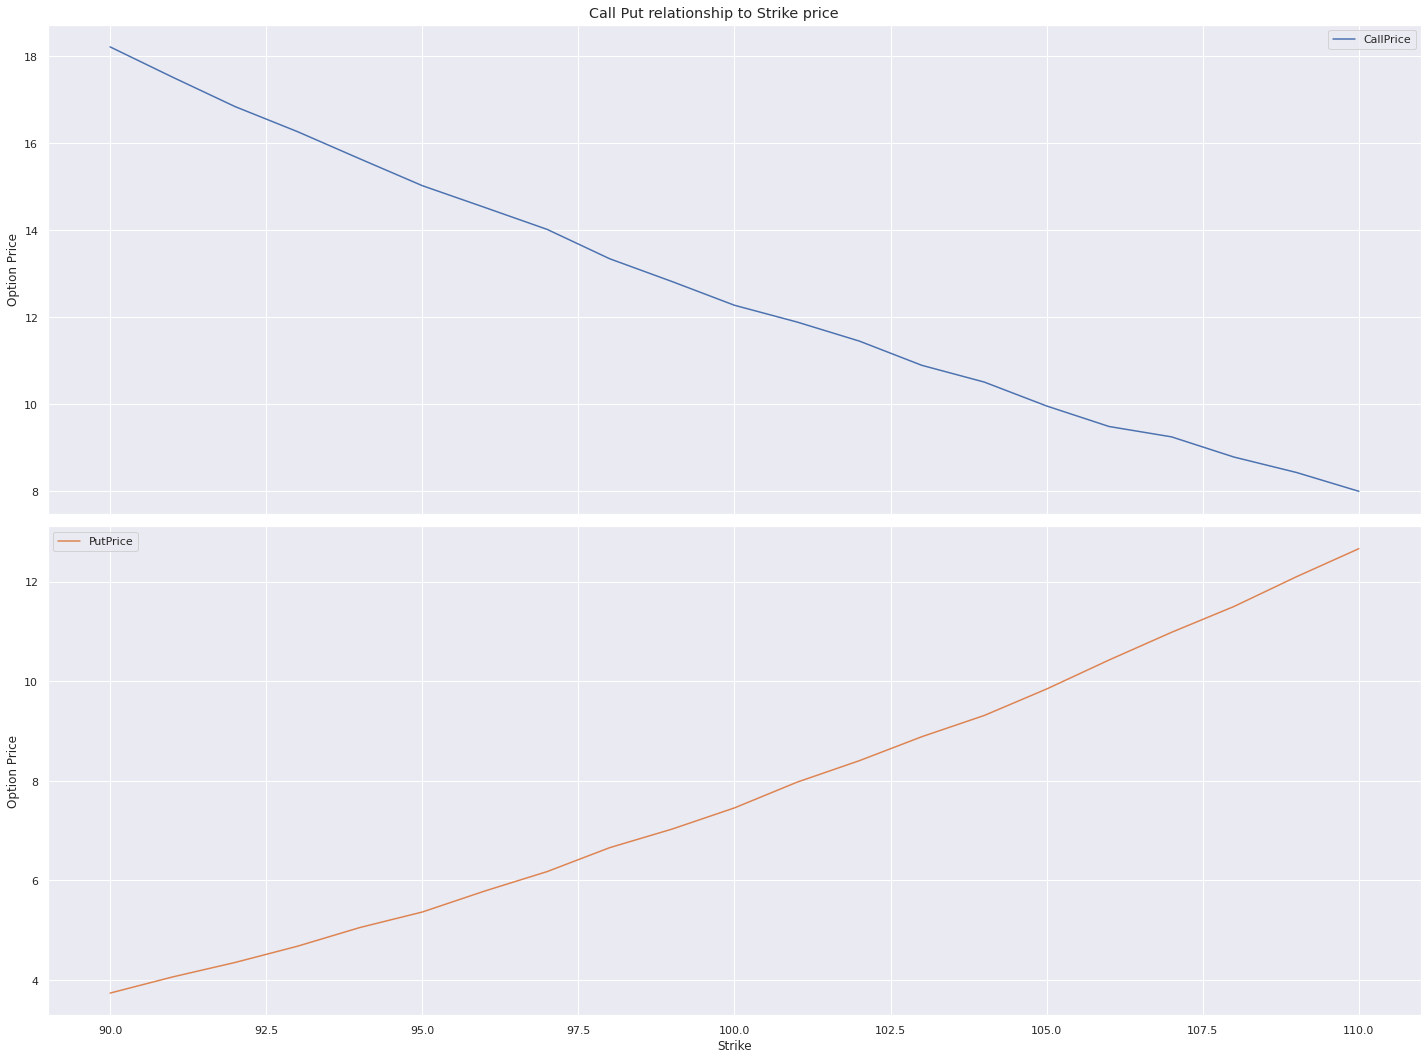

In [8]:
df.plot(subplots=True,
       figsize=(20,15),
        xlabel='Strike',
        ylabel='Option Price',
       title='Call Put relationship to Strike price')
plt.tight_layout();

The question is how well these simulation-based valuation approaches perform rela‐
tive to the benchmark value from the Black-Scholes-Merton valuation formula. To
find out, the following code generates respective option values/estimates for a range
of strike prices, using the analytical option pricing formula for European calls, defined below.

In [9]:
from math import log, sqrt, exp
from scipy import stats

def bsm_call_value(S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    : float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    Returns
    =======
    value: float
    present value of the European call option
    '''
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    # stats.norm.cdf --> cumulative distribution function
    #    for normal distribution
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) -    K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value

In [10]:
stat_res = []
dyna_res = []
anal_res = []
k_list = np.arange(80., 120.1, 5.)
np.random.seed(100)

In [11]:
for K in k_list:
    stat_res.append(gbm_mcs_stat(K))
    dyna_res.append(gbm_mcs_dyna(K))
    anal_res.append(bsm_call_value(S0, K, T, r, sigma))
stat_res = np.array(stat_res)
dyna_res = np.array(dyna_res)
anal_res = np.array(anal_res)

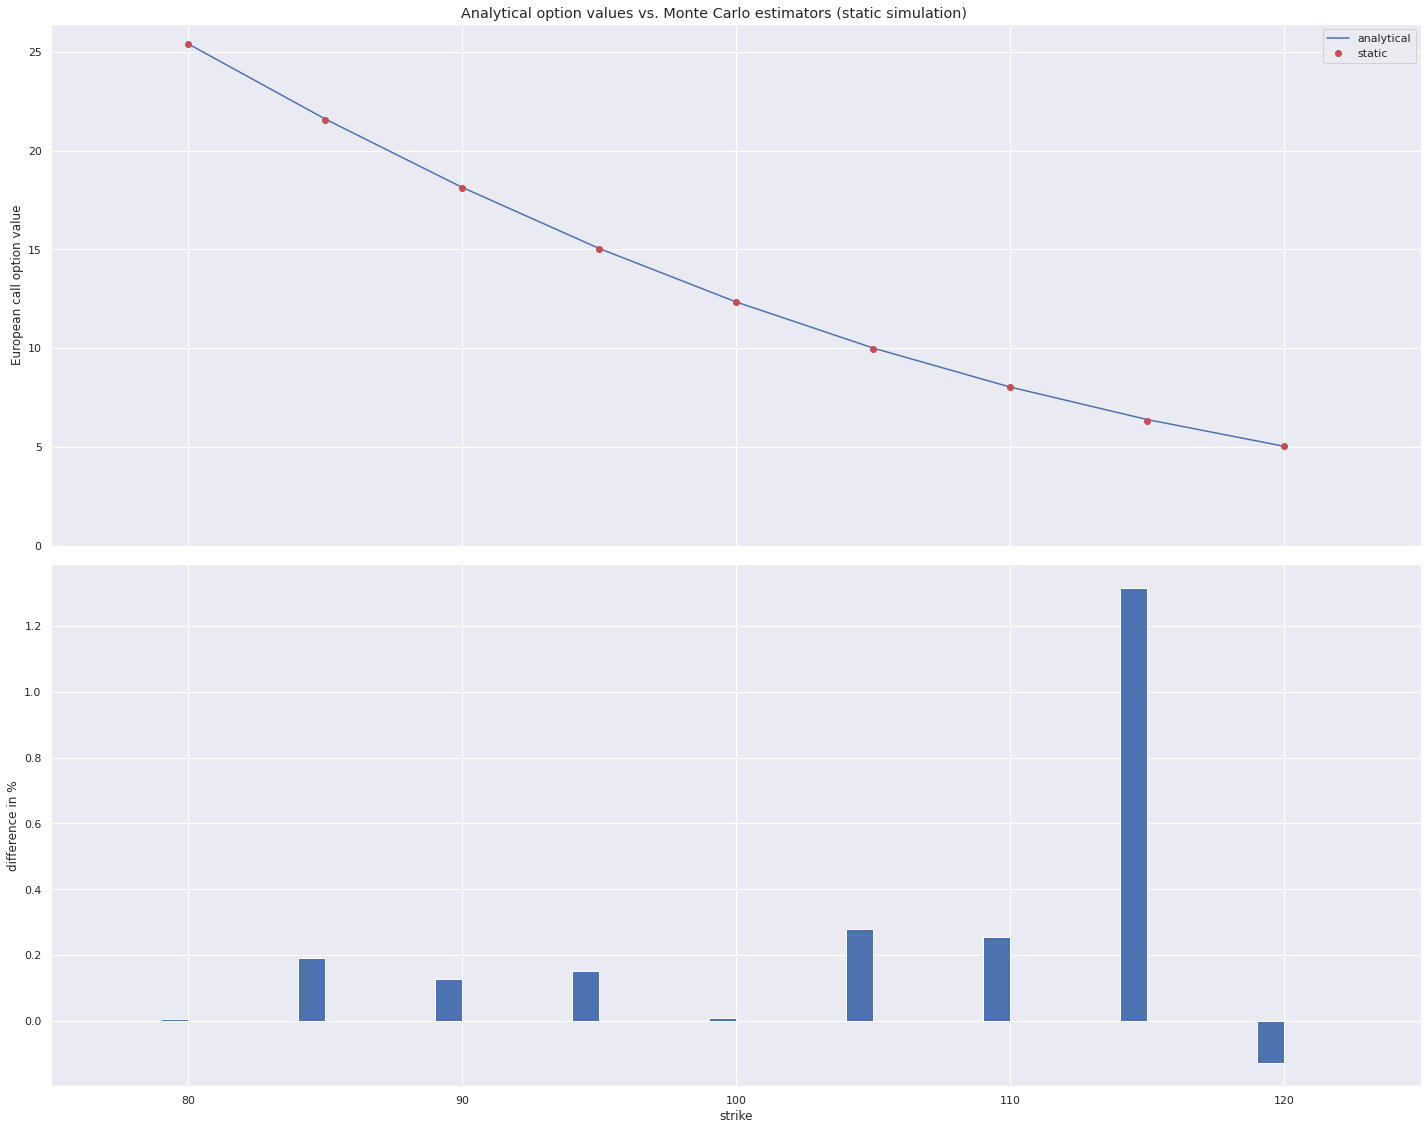

In [12]:
# plt.figure(figsize=(20, 16))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 16))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, stat_res, 'ro', label='static')
ax1.set_ylabel('European call option value')
ax1.legend(loc=0)
ax1.set_ylim(bottom=0)
wi = 1.0
ax2.bar(x=k_list - wi / 2, height=(anal_res - stat_res) / anal_res * 100, width=wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
plt.suptitle('Analytical option values vs. Monte Carlo estimators (static simulation)')
plt.tight_layout();

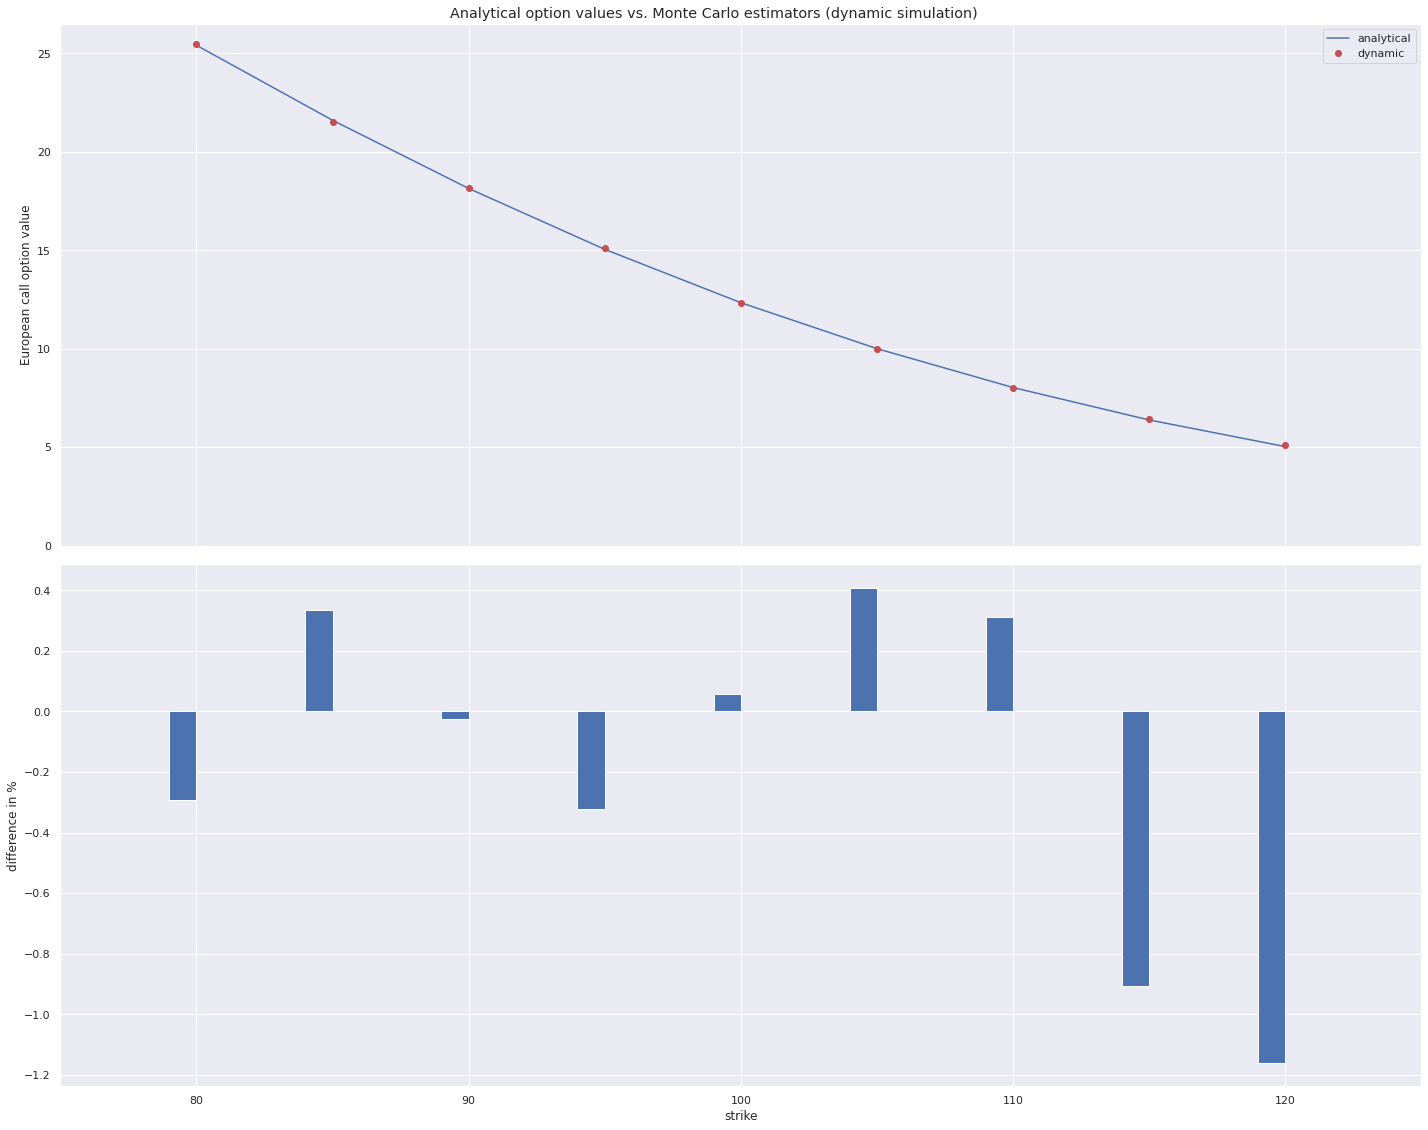

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 16))
ax1.plot(k_list, anal_res, 'b', label='analytical')
ax1.plot(k_list, dyna_res, 'ro', label='dynamic')
ax1.set_ylabel('European call option value')
ax1.legend(loc=0)
ax1.set_ylim(bottom=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (anal_res - dyna_res) / anal_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('difference in %')
ax2.set_xlim(left=75, right=125)
plt.suptitle('Analytical option values vs. Monte Carlo estimators (dynamic simulation)')
plt.tight_layout();

# American Options
The valuation of American options is more involved compared to European options.
In this case, an optimal stopping problem has to be solved to come up with a fair value
of the option. We shall study it, in dynamic setting -- ie. time interval divided into various $n$-parts.
Thinking each part to be a could be date for execution of option. This setting is called Bermuda option. 
If we recall, Bermuda is between European and American option.

For the time interval converging to zero
length, the value of the Bermudan option converges to the one of the American
option. Now, we perform **Valuation of American option in Black-Scholes-Merton
by Monte Carlo simulation by LSM algorithm**

In [14]:
def gbm_mcs_amer(K, option='call'):
    ''' Valuation of American option in Black-Scholes-Merton
    by Monte Carlo simulation by LSM algorithm
    Parameters
    ==========
    K: float
    (positive) strike price of the option
    option: string
    type of the option to be valued ('call', 'put')
    Returns
    =======
    C0: float
    estimated present value of American call option
    '''
    dt = T / M
    df = math.exp(-r * dt)
    # simulation of index levels
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt\
        + sigma * math.sqrt(dt) * sn[t])
    # case based calculation of payoff
    if option == 'call':
        h = np.maximum(S - K, 0)
    else:
        h = np.maximum(K - S, 0)
    # LSM algorithm
    V = np.copy(h)
    for t in range(M - 1, 0, -1):
        reg = np.polyfit(S[t], V[t + 1] * df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
    # MCS estimator
    C0 = df * np.mean(V[1])
    return C0

In [15]:
gbm_mcs_amer(110., option='call'),gbm_mcs_amer(110., option='put')

(7.721705606305352, 13.609997625418051)

The European value of an option represents a lower bound to the American option’s
value. The difference is generally called the early exercise premium. What follows
compares European and American option values for the same range of strikes as
before to estimate the early exercise premium, this time with puts:

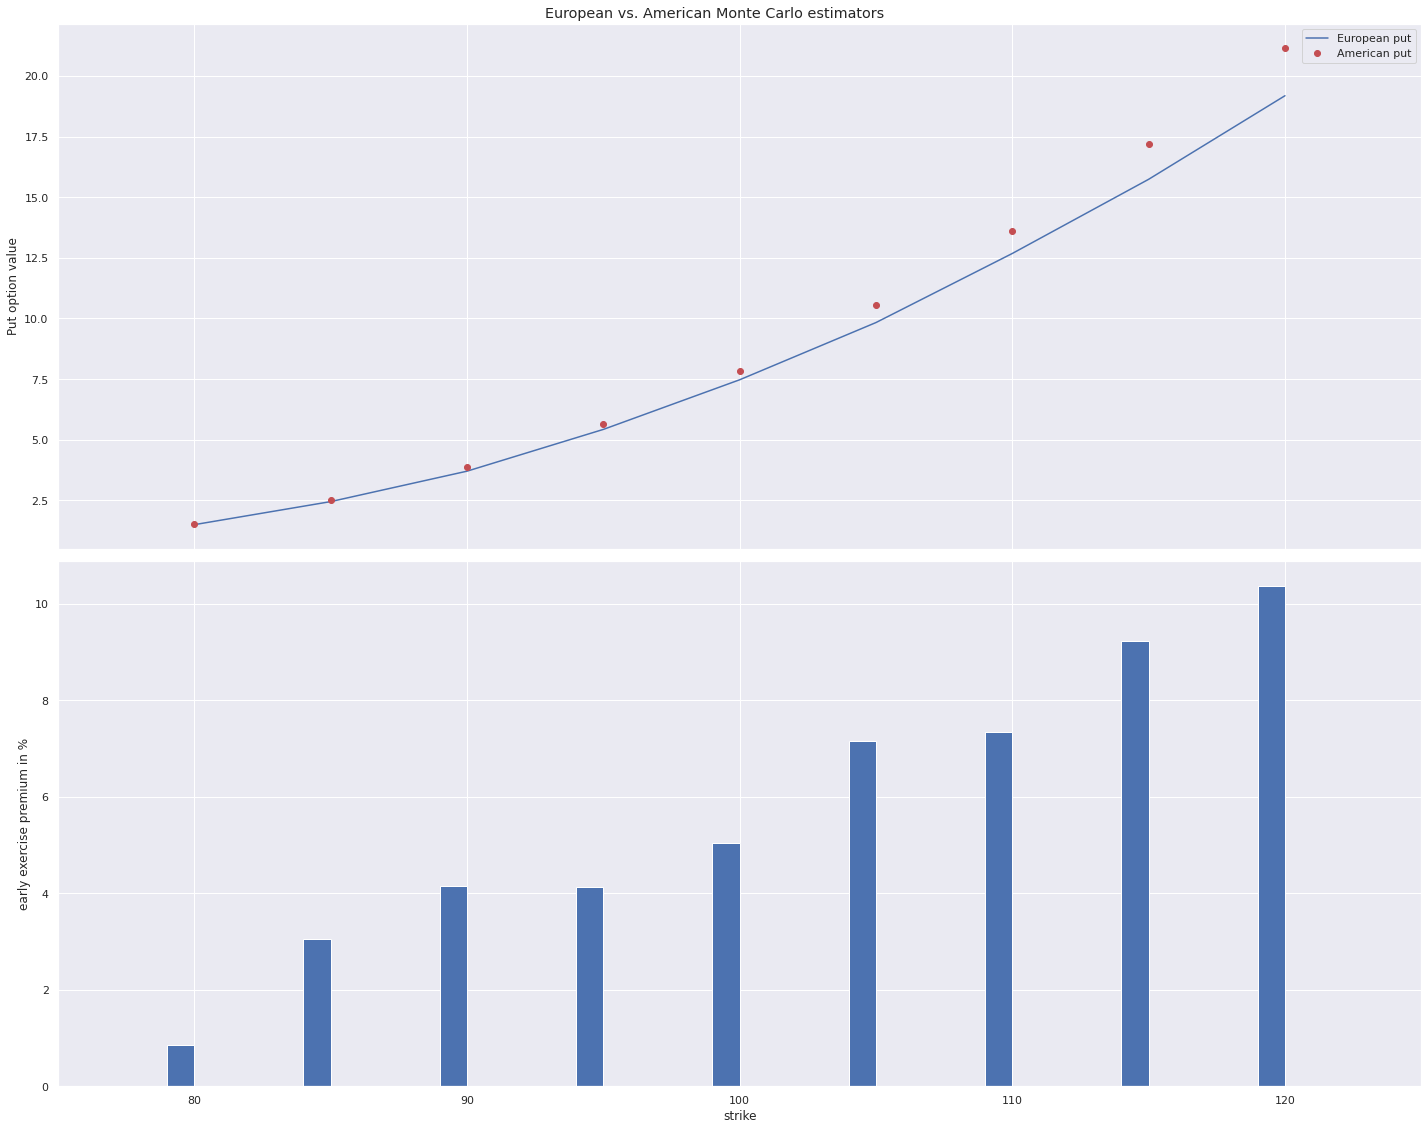

In [16]:
euro_res = []
amer_res = []
k_list = np.arange(80., 120.1, 5.)

for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'put'))
    amer_res.append(gbm_mcs_amer(K, 'put'))
    
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 16))
ax1.plot(k_list, euro_res, 'b', label='European put')
ax1.plot(k_list, amer_res, 'ro', label='American put')
ax1.set_ylabel('Put option value')
ax1.legend(loc=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / euro_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125);
plt.suptitle('European vs. American Monte Carlo estimators')
plt.tight_layout()

The figure shows that for the range of strikes chosen the early exercise premium
can rise to up to 10%

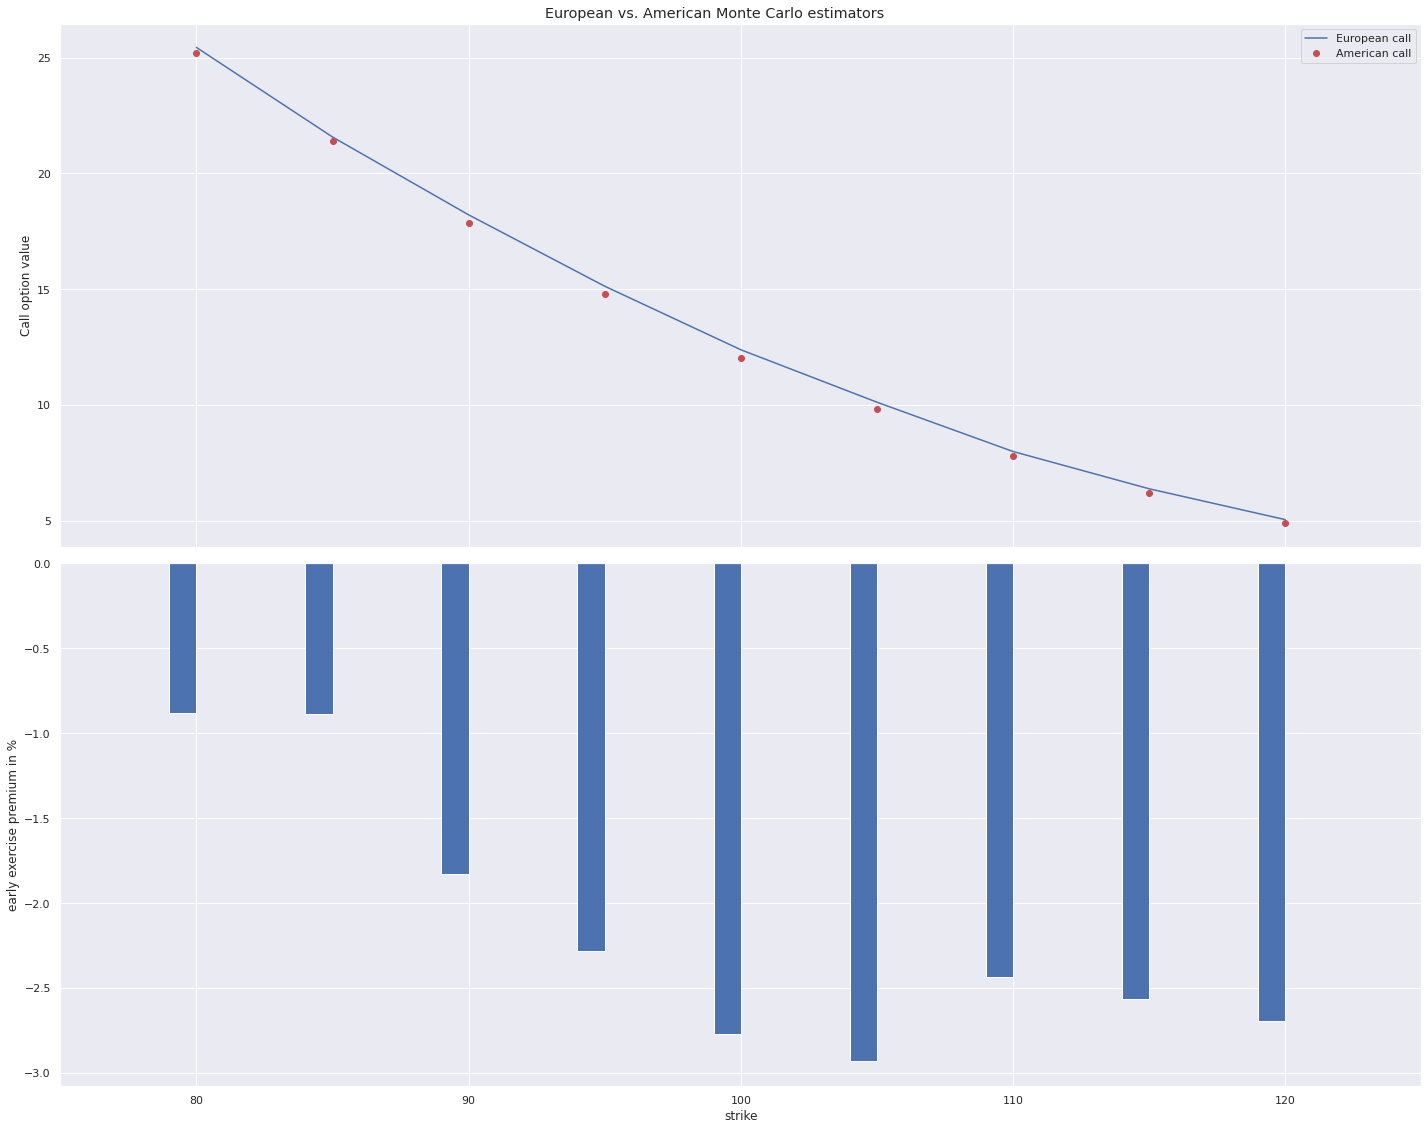

In [17]:
euro_res = []
amer_res = []
k_list = np.arange(80., 120.1, 5.)

for K in k_list:
    euro_res.append(gbm_mcs_dyna(K, 'call'))
    amer_res.append(gbm_mcs_amer(K, 'call'))
    
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 16))
ax1.plot(k_list, euro_res, 'b', label='European call')
ax1.plot(k_list, amer_res, 'ro', label='American call')
ax1.set_ylabel('Call option value')
ax1.legend(loc=0)
wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / euro_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125);
plt.suptitle('European vs. American Monte Carlo estimators')
plt.tight_layout()

# Risk Measures
In addition to valuation, risk management is another important application area of
stochastic methods and simulation. This section illustrates the calculation/estimation
of two of the most common risk measures applied today in the finance industry.

# Value-at-Risk
Value-at-risk (VaR) is one of the most widely used risk measures, and a much deba‐
ted one. Loved by practitioners for its intuitive appeal, it is widely discussed and criti‐
cized by many—mainly on theoretical grounds, with regard to its limited ability to
capture what is called tail risk (more on this shortly). In words, VaR is a number
denoted in currency units (e.g., USD, EUR, JPY) indicating a loss (of a portfolio, a
single position, etc.) that is not exceeded with some confidence level (probability)
over a given period of time.

**Consider a stock position, worth 1 million USD today, that has a VaR of 50,000 USD
at a confidence level of 99% over a time period of 30 days (one month). This VaR
figure says that with a probability of 99% (i.e., in 99 out of 100 cases), the loss to be
expected over a period of 30 days will not exceed 50,000 USD. However, it does not
say anything about the size of the loss once a loss beyond 50,000 USD occurs—i.e., if
the maximum loss is 100,000 or 500,000 USD what the probability of such a specific
“higher than VaR loss” is. All it says is that there is a 1% probability that a loss of a
minimum of 50,000 USD or higher will occur.**

Assume the Black-Scholes-Merton setup and consider the following parameterization
and simulation of index levels at a future date T = 30/365 (a period of 30 days). The
estimation of VaR figures requires the simulated absolute profits and losses relative
to the value of the position today in a sorted manner, i.e., from the severest loss to the
largest profit.

Text(0.5, 1.0, 'Absolute profits and losses from simulation (geometric Brownian motion)')

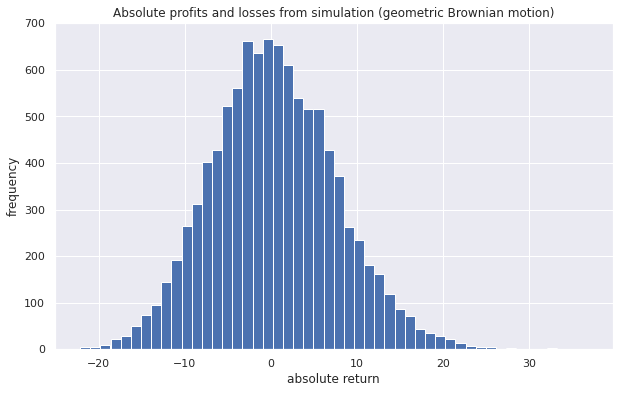

In [18]:
S0 = 100
r = 0.05
sigma = 0.25
T = 30 / 365.
I = 10000

ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T +
sigma * np.sqrt(T) * npr.standard_normal(I))

R_gbm = np.sort(ST - S0)

plt.figure(figsize=(10, 6))
plt.hist(R_gbm, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency');
plt.title('Absolute profits and losses from simulation (geometric Brownian motion)')

Having the ndarray object with the sorted results, the scs.scoreatpercentile()
function already does the trick. All one has to do is to define the percentiles of inter‐
est (in percent values). In the list object percs , 0.1 translates into a confidence level
of 100% – 0.1% = 99.9%.

In [19]:
import scipy.stats as scs

percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_gbm, percs)
print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))
    
print(f'\n\nThe 30-day VaR given a confidence level of 99.9% in this\
case is {-scs.scoreatpercentile(R_gbm, .1)} currency units, while it is \
{-scs.scoreatpercentile(R_gbm, 10)} at the 90% confidence level.')

Confidence Level    Value-at-Risk
---------------------------------
           99.99           22.128
           99.90           19.715
           99.00           15.519
           97.50           13.168
           95.00           11.074
           90.00            8.815


The 30-day VaR given a confidence level of 99.9% in thiscase is 19.714878624915844 currency units, while it is 8.81462363026554 at the 90% confidence level.


As a second example, recall the jump diffusion setup from Merton, which is simula‐
ted dynamically. In this case, with the jump component having a negative mean, one
sees something like a bimodal distribution for the simulated profits/losses. 
From a normal distribution point of view, one sees a pronounced left
fat tail:

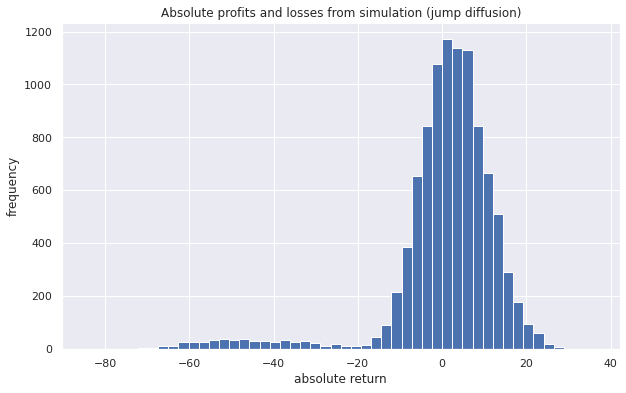

In [20]:
lamb = .75
mu = -0.6
delta = 0.25

dt = 30. / 365 / M
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)

S = np.zeros((M + 1, I))
S[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt\
    + sigma * math.sqrt(dt) * sn1[t])\
    + (np.exp(mu + delta * sn2[t]) - 1)\
    * poi[t])
    S[t] = np.maximum(S[t], 0)
    
R_jd = np.sort(S[-1] - S0)

plt.figure(figsize=(10, 6))
plt.hist(R_jd, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.title('Absolute profits and losses from simulation (jump diffusion)');

For this process and parameterization, the VaR over 30 days at the 90% level is
almost identical as with the geometric Brownian motion, while it is more than three
times as high at the 99.9% level.

In [21]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_jd, percs)
print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))
    
print(f'\n\nThe VaR over 30 days at the 90% level is almost identical as with the geometric \
Brownian motion - {scs.scoreatpercentile(R_jd, 10)/scs.scoreatpercentile(R_gbm, 10)} \
to be exact, \n\
while it is more than three times, {scs.scoreatpercentile(R_jd, .010) / scs.scoreatpercentile(R_gbm, .010)} \
to be exact, as high at the 99.9% level.')

Confidence Level    Value-at-Risk
---------------------------------
           99.99           81.488
           99.90           70.256
           99.00           57.512
           97.50           47.259
           95.00           26.067
           90.00            8.928


The VaR over 30 days at the 90% level is almost identical as with the geometric Brownian motion - 1.0128407774466937 to be exact, 
while it is more than three times, 3.6826015709593887 to be exact, as high at the 99.9% level.


This illustrates the problem of capturing the tail risk so often encountered in finan‐
cial markets by the standard VaR measure.
To further illustrate the point, we see the VaR measures for both
cases in direct comparison graphically. As the plot reveals, the VaR measures behave
completely differently given a range of typical confidence levels:

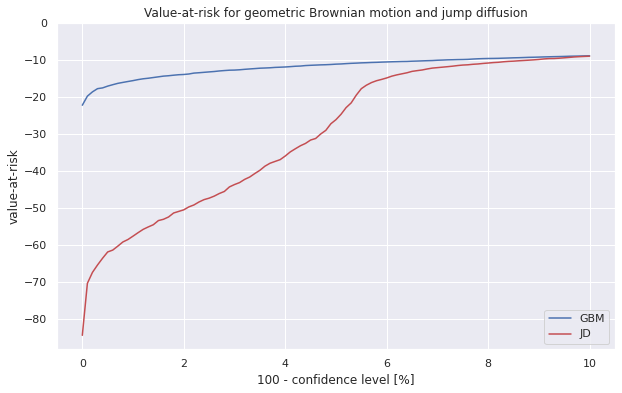

In [22]:
percs = list(np.arange(0.0, 10.1, 0.1))
gbm_var = scs.scoreatpercentile(R_gbm, percs)
jd_var = scs.scoreatpercentile(R_jd, percs)

plt.figure(figsize=(10, 6))
plt.plot(percs, gbm_var, 'b', lw=1.5, label='GBM')
plt.plot(percs, jd_var, 'r', lw=1.5, label='JD')
plt.legend(loc=4)
plt.xlabel('100 - confidence level [%]')
plt.ylabel('value-at-risk')
plt.ylim(ymax=0.0)
plt.title('Value-at-risk for geometric Brownian motion and jump diffusion');

# Credit Valuation Adjustments
Other important risk measures are the credit value-at-risk (CVaR) and the credit valuation adjustment (CVA), which is derived from the CVaR. Roughly speaking, CVaR
is a measure for the risk resulting from the possibility that a counterparty might not
be able to honor its obligations—for example, if the counterparty goes bankrupt. In
such a case there are two main assumptions to be made: the probability of default and
the (average) loss level.
To make it specific, consider again the benchmark setup of Black-Scholes-Merton
with the parameterization in the following code. In the simplest case, one considers a
fixed (average) loss level $L$ and a fixed probability p of default (per year) of a counterparty. Using the Poisson distribution, default scenarios are generated as follows, taking into account that a default can only occur once:

In [23]:
S0 = 100.
r = 0.05
sigma = 0.2
T = 1.
I = 100000

ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T\
+ sigma * np.sqrt(T) * npr.standard_normal(I))

L = 0.5
p = .01

D = npr.poisson(p * T, I)
D = np.where(D > 1, 1, D)

Without default, the risk-neutral value of the future index level should be equal to the
current value of the asset today (up to differences resulting from numerical errors).
The CVaR and the present value of the asset, adjusted for the credit risk, are given as
follows:

In [24]:
math.exp(-r * T) * np.mean(ST) #Discounted average simulated value of the asset at T.

100.04550002788295

In [25]:
CVaR = math.exp(-r * T) * np.mean(L * D * ST) #CVaR as the discounted average of the future losses in the case of a default.
CVaR

0.461387936868919

In [26]:
'''Discounted average simulated value of the asset at T, adjusted for the simulated
losses from default.'''
S0_CVA = math.exp(-r * T) * np.mean((1 - L * D) * ST)
S0_CVA

99.58411209101405

In [27]:
#Current price of the asset adjusted by the simulated CVaR.
S0_adj = S0 - CVaR
S0_adj

99.53861206313108

In [28]:
# Number of default events and therewith loss events.
np.count_nonzero(L * D * ST)

931

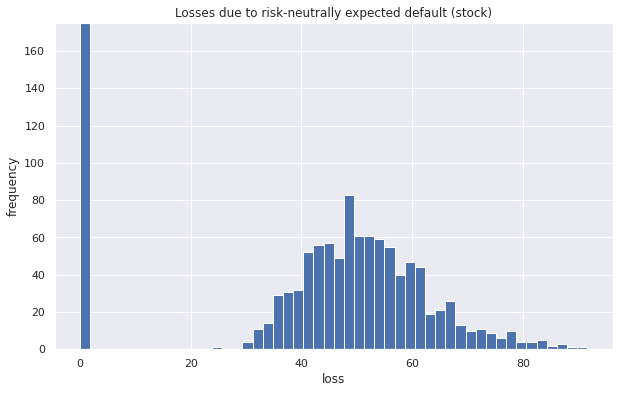

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(L * D * ST, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.ylim(ymax=175)
plt.title('Losses due to risk-neutrally expected default (stock)');

Consider now the case of a European call option.

In [30]:
K = 100.
hT = np.maximum(ST - K, 0)
C0 = math.exp(-r * T) * np.mean(hT)
CVaR = math.exp(-r * T) * np.mean(L * D * hT)
C0_CVA = math.exp(-r * T) * np.mean((1 - L * D) * hT)
print(f'European call option value is about {C0} currency\
units at a strike of {K}. The CVaR is about {CVaR*100} cents given the same assumptions with\
regard to probability of default = {p} and loss level = {L}.')

European call option value is about 10.482890726915281 currencyunits at a strike of 100.0. The CVaR is about 4.7648617195593035 cents given the same assumptions withregard to probability of default = 0.01 and loss level = 0.5.


In [31]:
'''The number of losses due to default = np.count_nonzero(L * D * hT)
The number of defaults.np.count_nonzero(D)
The number of cases for which the option expires worthless.= I - np.count_nonzero(hT)
'''
print(f'Compared to the case of a regular asset, the option case has somewhat different char\
acteristics. One only sees a little more than {np.count_nonzero(L * D * hT)} losses due to a default, although there\
are again {np.count_nonzero(D)} defaults in total. This results from the fact that the payoff of the\
option at maturity has a high probability of being zero.')

Compared to the case of a regular asset, the option case has somewhat different characteristics. One only sees a little more than 492 losses due to a default, although thereare again 931 defaults in total. This results from the fact that the payoff of theoption at maturity has a high probability of being zero.


In [32]:
print(f'The number of cases for which the option expires worthless = {I - np.count_nonzero(hT)}')
# I - np.count_nonzero(hT)

The number of cases for which the option expires worthless = 44077


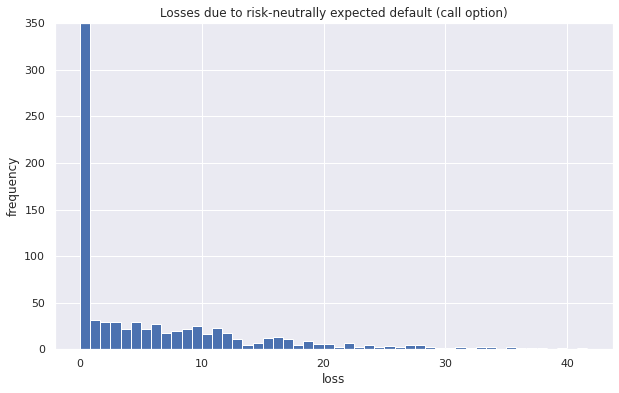

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(L * D * hT, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.ylim(ymax=350)
plt.title('Losses due to risk-neutrally expected default (call option)');

The following presents an implementation of central functions related to the Black-
Scholes-Merton model for the analytical pricing of European (call) options. For
details of the model, see Black and Scholes (1973) as well as Merton (1973).

In [34]:
'''Valuation of European call options
in Black-Scholes-Merton model
incl. vega function and implied volatility estimation
bsm_functions.py
(c) Dr. Yves J. Hilpisch
Python for Finance, 2nd ed.'''

from math import log, sqrt,exp
from scipy import stats

def bsm_call_value(S0, K, T, r, sigma):
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float

    T: float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    Returns
    =======
    value: float
    present value of the European call option
    '''
#     from math import log, sqrt, exp
#     from scipy import stats
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    # stats.norm.cdf --> cumulative distribution function
    #    for normal distribution
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) -\
            K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value

def bsm_vega(S0, K, T, r, sigma):
    ''' Vega of European option in BSM model.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    strike price
    T: float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    Returns
    =======
    vega: float
    partial derivative of BSM formula with respect
    to sigma, i.e. vega
    '''

    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega


# Implied volatility function
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    ''' Implied volatility of European call option in BSM model.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    strike price
    T: float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma_est: float
    estimate of impl. volatility
    it: integer
    number of iterations
    Returns
    =======

    simga_est: float
    numerically estimated implied volatility
    '''
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) /
                      bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

In [35]:
value = bsm_call_value(100., 105., 1.0, 0.05, 0.2)
vega = bsm_vega(100., 105., 1.0, 0.05, 0.2)
imp_vol = bsm_call_imp_vol(100., 105., 1.0, 0.05, C0=value, sigma_est=0.2)

In [36]:
print(f'Suppose S0, K, T, r, sigma = 100., 105., 1.0, 0.05, 0.2 then :\n\nThe value of a call option using BSM is : \
{value} and vega is {vega}. \n\nThe imported volatility for S0, K, T, r, C0, sigma_est = 100., 105.,\
1.0, 0.05, {value}, 0.2 is given by {imp_vol}')

Suppose S0, K, T, r, sigma = 100., 105., 1.0, 0.05, 0.2 then :

The value of a call option using BSM is : 8.021352235143176 and vega is 39.67052380842653. 

The imported volatility for S0, K, T, r, C0, sigma_est = 100., 105.,1.0, 0.05, 8.021352235143176, 0.2 is given by 0.2
